# Neural Network Final Model - Cape Matatula, American Samoa

In [1]:
import pandas as pd
import numpy as np
from joblib import dump
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import sys
sys.path.append('../../')
import config as cfg
import functions as f

data_path = Path.home()/'OneDrive'/'Kirstin'/'Uni'/'Year4'/'MSciProject'/'data_files'/'saved_files'

In [2]:
site = cfg.site
site_name = cfg.site_dict[site]
assert site == 'SMO', 'This script is only for Cape Matatula, American Samoa. The site can be changed in the config file.'

compound = cfg.compound

print(f"Creating a neural network model for \033[1m{site_name}\033[0;0m.")

Creating a neural network model for Cape Matatula, American Samoa.


### Loading & Initialising Data

In [3]:
data = pd.read_csv(data_path/f'for_model_{compound}_{site}.csv', parse_dates=['time'])
data.sample(5)

,time,flag,u10_0,u10_1,u10_2,u10_3,u10_4,u10_5,u10_6,u10_7,...,v500_7_past,v500_8_past,v500_9_past,v500_10_past,v500_11_past,v500_12_past,v500_13_past,v500_14_past,v500_15_past,v500_16_past
28569,2010-10-10 19:00:00,1.0,-6.332552,-7.313867,-7.354239,-7.050451,-4.853586,-5.899655,-3.115999,-3.923435,...,-2.198181,-2.879254,0.832727,1.770194,-1.402567,-6.508413,-6.605331,-4.333913,-4.824673,-0.498582
36645,2013-08-26 21:00:00,1.0,-2.516882,-4.126697,-5.542696,-6.013250,-2.042954,-2.431064,-2.810014,-6.522855,...,-3.060643,-4.418996,0.482045,0.337928,1.419878,-10.360043,0.543348,1.551089,-4.357693,-6.015034
40364,2015-04-07 11:00:00,0.0,-1.434467,-2.250653,-2.786054,1.102961,3.425576,-4.885676,-7.914343,-4.892219,...,4.733374,-0.319780,1.588627,0.276391,-3.816508,-7.569525,4.010709,11.469443,2.116601,-2.569170
27746,2010-07-08 03:00:00,1.0,-4.129637,-5.941292,-6.621566,-7.145966,-1.714096,0.909449,-0.653943,-4.590551,...,3.400117,-0.136435,2.926638,5.337078,6.071145,-2.038495,-6.955932,8.195403,0.891957,-1.752314
6729,2002-06-25 23:00:00,1.0,-7.872538,-7.225000,-7.805198,-6.431631,-7.688356,-8.735030,-6.756739,-7.949244,...,-3.701479,-1.502409,2.698268,0.407213,3.359339,-7.043623,-1.523259,4.471751,-4.287734,-1.433726


In [4]:
train_data = data[(data['time'].dt.year >= 2018) & (data['time'].dt.year <= 2018)]
val_data = data[(data['time'].dt.year >= 2019) & (data['time'].dt.year <= 2019)]
test_data = data[(data['time'].dt.year >= 2020) & (data['time'].dt.year <= 2023)]

print(f"Train range: {train_data['time'].min()} -> {train_data['time'].max()}. Length: {len(train_data)}")
print(f"Val range: {val_data['time'].min()} -> {val_data['time'].max()}. Length: {len(val_data)}")
print(f"Test range: {test_data['time'].min()} -> {test_data['time'].max()}. Length: {len(test_data)}")


# Drop the "time" column as it won't be used in the model
train_data = train_data.drop(columns=['time'])
val_data = val_data.drop(columns=['time'])
test_data = test_data.drop(columns=['time'])

# Define the features (X) and the target (y)
X_train = train_data.drop(columns=['flag'])
y_train = train_data['flag']
X_val = val_data.drop(columns=['flag'])
y_val = val_data['flag']
X_test = test_data.drop(columns=['flag'])
y_test = test_data['flag']

# Balanced Data - removing NaN values and associated data
y_train = y_train.dropna()
y_val = y_val.dropna()
y_test = y_test.dropna()

# aligning indices of features sets
X_train = X_train.loc[y_train.index]
X_val = X_val.loc[y_val.index]
X_test = X_test.loc[y_test.index]

Train range: 2018-01-01 15:00:00 -> 2018-12-31 23:00:00. Length: 2379
Val range: 2019-01-01 01:00:00 -> 2019-12-31 23:00:00. Length: 2126
Test range: 2020-01-01 01:00:00 -> 2022-12-31 23:00:00. Length: 7925


### Model

In [5]:
nn_model = MLPClassifier(random_state=42,
                         max_iter=1000, 
                         hidden_layer_sizes=(100,), 
                         shuffle=False,
                         activation='relu', 
                         solver='adam', 
                         alpha=0.001, 
                         learning_rate='constant', 
                         batch_size=100, 
                         early_stopping=True,
                         learning_rate_init=0.001,
                         beta_2=0.9,)

nn_model.fit(X_train, y_train)

class_probabilities_val = nn_model.predict_proba(X_val)
class_probabilities_train = nn_model.predict_proba(X_train)

confidence_threshold = cfg.confidence_threshold

y_pred_val = (class_probabilities_val[:,1] > confidence_threshold).astype(int)
y_pred_train = (class_probabilities_train[:,1] > confidence_threshold).astype(int)

precision_val = precision_score(y_val, y_pred_val)
precision_train = precision_score(y_train, y_pred_train)
recall_val = recall_score(y_val, y_pred_val)
recall_train = recall_score(y_train, y_pred_train)
f1_val = f1_score(y_val, y_pred_val)
f1_train = f1_score(y_train, y_pred_train)
misclassification_rate_val = 1 - accuracy_score(y_val, y_pred_val)
misclassification_rate_train = 1 - accuracy_score(y_train, y_pred_train)

print(f"Precision on Training Set = {precision_train:.3f}")
print(f"Precision on Validation Set = {precision_val:.3f}")
print(f"Recall on Training Set = {recall_train:.3f}")
print(f"Recall on Validation Set = {recall_val:.3f}")
print(f"F1 Score on Training Set = {f1_train:.3f}")
print(f"F1 Score on Validation Set = {f1_val:.3f}")
print(f"Misclassification Rate on Training Set = {misclassification_rate_train:.3f}")
print(f"Misclassification Rate on Validation Set = {misclassification_rate_val:.3f}")

Precision on Training Set = 0.850
Precision on Validation Set = 0.740
Recall on Training Set = 0.849
Recall on Validation Set = 0.654
F1 Score on Training Set = 0.850
F1 Score on Validation Set = 0.695
Misclassification Rate on Training Set = 0.226
Misclassification Rate on Validation Set = 0.405


In [6]:
# evaluating model on test set
class_probabilities_test = nn_model.predict_proba(X_test)

y_pred_test = (class_probabilities_test[:,1] > confidence_threshold).astype(int)

precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test)
misclassification_rate_test = 1 - accuracy_score(y_test, y_pred_test)

print(f"Precision on Testing Set = {precision_test:.3f}")
print(f"Recall on Testing Set = {recall_test:.3f}")
print(f"F1 Score on Testing Set = {f1_test:.3f}")
print(f"Misclassification Rate on Testing Set = {misclassification_rate_test:.3f}")

Precision on Testing Set = 0.866
Recall on Testing Set = 0.822
F1 Score on Testing Set = 0.844
Misclassification Rate on Testing Set = 0.250


In [7]:
# saving the model
dump(nn_model, data_path/f'nn_model_{site}.joblib')
dump(nn_model, f'../model_files/nn_model_{site}.joblib')

['../model_files/nn_model_SMO.joblib']

### Confusion Matrix

Text(0.5, 1.0, 'Cape Matatula, American Samoa')

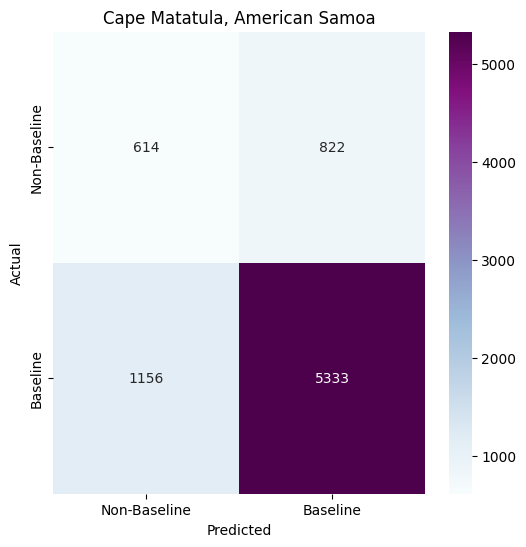

In [8]:
# creating a confusion matrix
conf_matrix = pd.crosstab(y_test, y_pred_test, rownames=['Actual'], colnames=['Predicted'])

conf_matrix.columns = ['Non-Baseline', 'Baseline']
conf_matrix.index = ['Non-Baseline', 'Baseline']

fig, ax = plt.subplots(figsize=(6, 6))

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='BuPu', cbar=True, ax=ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

ax.set_title(f'{site_name}')

### Assessing Feature Importance

In [9]:
# grouping features by category i.e. x-wind, y-wind, temporal etc.
u_features = [col for col in data.columns if 'u' in col]
v_features = [col for col in data.columns if 'v' in col]
temporal_features = ['day_of_year', 'time_of_day']
sp = ['sp']
blh = ['blh']

groups = [u_features, v_features, temporal_features, sp, blh]

In [10]:
original_score = accuracy_score(y_train, nn_model.predict(X_train))
importances = {}

for group in groups:
    scores_diff = []
    for _ in range(100):
        X_train_permuted = f.permute_group(X_train, group)
        
        permuted_score = accuracy_score(y_train, nn_model.predict(X_train_permuted))
        scores_diff.append(original_score - permuted_score)
    
    importances[str(group)] = np.mean(scores_diff)

# Sort groups by importance
sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=False)

In [11]:
# matching the group names to the sorted importances
n = len(groups)
group_names_sorted = []

for i in range(n):
    name = sorted_importances[i][0]

    if 'u10_0' in name:
        group_names_sorted.append('u-wind')

    elif 'v10_0' in name:
        group_names_sorted.append('v-wind')

    elif 'day_of_year' in name:
        group_names_sorted.append('temporal')

    elif 'sp' in name:
        group_names_sorted.append('sp')

    elif 'blh' in name:
        group_names_sorted.append('blh')

Text(0, 0.5, 'Feature Group')

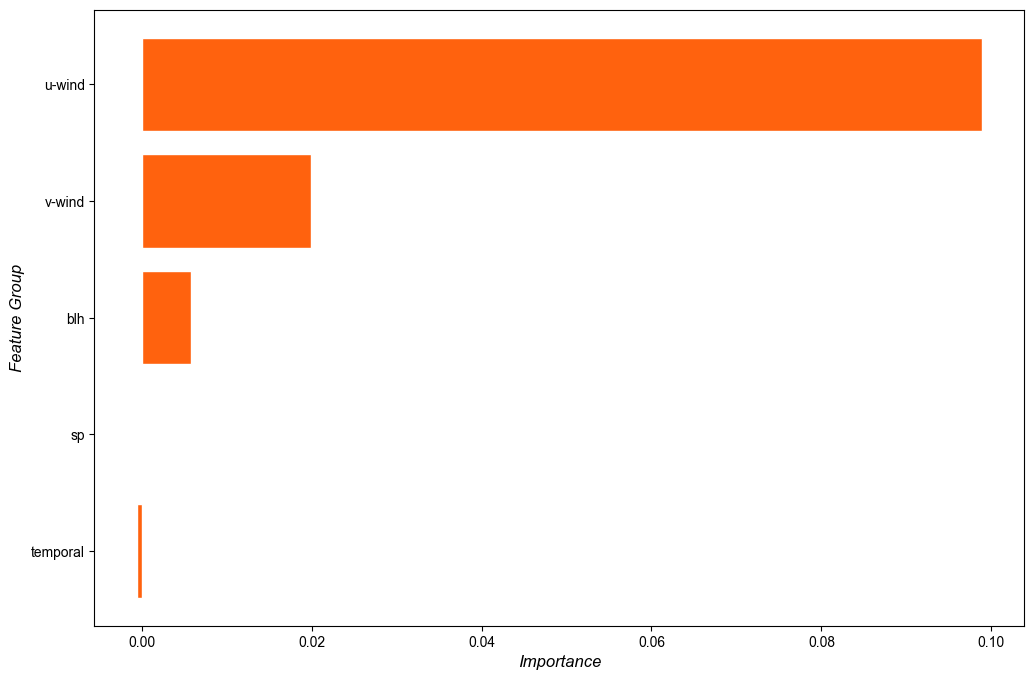

In [12]:
# Plotting the importances of the groups
fig, ax = plt.subplots(figsize=(12, 8))
sns.set_theme(style='ticks', font='Arial')

ax.barh(group_names_sorted, [importance for _, importance in sorted_importances], color='#FF620E')

ax.set_xlabel('Importance', fontsize=12, fontstyle='italic')
ax.set_ylabel('Feature Group', fontsize=12, fontstyle='italic')
# ax.set_title('Permutation Importances', fontsize=14)